In [ ]:
!pip -q install kagglehub cleanlab pymorphy3 pymorphy2-dicts-ru razdel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.1/306.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 113.2 MB/s eta 0:00:00


### Задача

**Модерация комментариев в региональном новостном портале**

Функциональные требования:

- Классификация комментариев пользователей на "токсичные/нормальные" в реальном времени

- Обработка 500-1000 комментариев в час в пиковое время

- *Точность* не ниже 75% (с возможностью ручной проверки спорных случаев)

Нефункциональные требования и ограничения:

- Бюджет проекта: 150 тыс. рублей на весь цикл разработки и внедрения

- Инфраструктура: один сервер с 4 ядрами CPU, 8GB RAM, без GPU

- Время отклика: не более 100ms на один комментарий

- SLA 99.5% — нельзя допустить падения модели из-за нехватки ресурсов

- Запрет на передачу данных третьим сторонам (нельзя использовать API внешних LLM)

### Импорты и настройка среды

In [ ]:
import gc
import os
import re
import time
import json
import math
import string
import random
import tracemalloc

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer

import kagglehub

from cleanlab.filter import find_label_issues

import razdel
import pymorphy3

from joblib import Memory

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Датасет

In [ ]:
dataset_name = "blackmoon/russian-language-toxic-comments"
path = kagglehub.dataset_download(dataset_name)
path

Using Colab cache for faster access to the 'russian-language-toxic-comments' dataset.


'/kaggle/input/russian-language-toxic-comments'

In [ ]:
!ls {path}

labeled.csv


In [ ]:
df = pd.read_csv(path + '/labeled.csv')
df['toxic'] = df['toxic'].astype(int)
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [ ]:
df.isna().sum()

,0
comment,0
toxic,0


In [ ]:
df.shape

(14412, 2)

### Базовый EDA

Распределение классов и длин текстов по классам

In [ ]:
df["len_chars"] = df["comment"].str.len()
df["len_words"] = df["comment"].str.split().str.len()

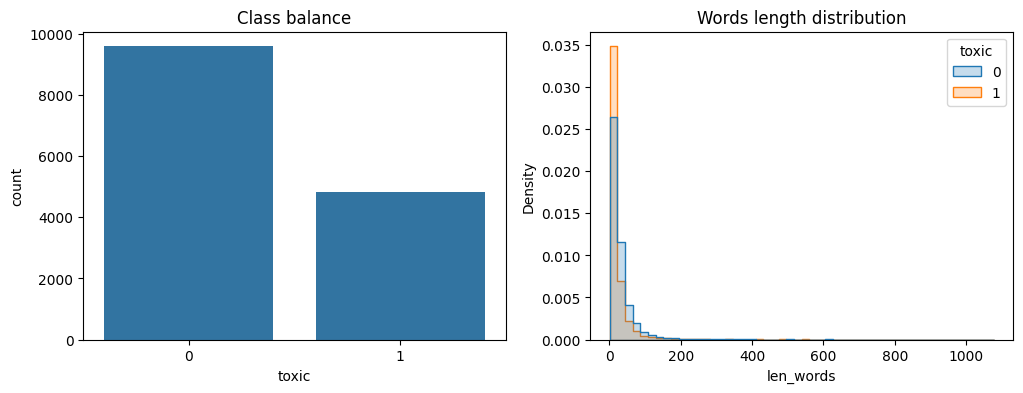

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x="toxic", data=df, ax=ax[0])
ax[0].set_title("Class balance")
sns.histplot(data=df, x="len_words", hue="toxic", bins=50, element="step", stat="density", common_norm=False, ax=ax[1])
ax[1].set_title("Words length distribution")
plt.show()

In [ ]:
df["toxic"].value_counts(normalize=True)

,proportion
toxic,
0,0.66514
1,0.33486


Дубликаты

In [ ]:
df["text_norm_simple"] = (
    df["comment"].str.lower()
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

In [ ]:
df.duplicated("text_norm_simple").sum()

np.int64(257)

Конфликтующая разметка по дубликатам

In [ ]:
(df.groupby("text_norm_simple")["toxic"].nunique() > 1).sum()

np.int64(43)

### Фильтрация непригодных для обучения примеров

In [ ]:
df[df['len_words'] < 2]

,comment,toxic,len_chars,len_words,text_norm_simple
5991,БЛЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯ\n,1,44,1,бляяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяяя
6308,АРТАС-ПИДАРАААААААААААААС!!!!!!\n,1,32,1,артас-пидарааааааааааааас!!!!!!
8433,А-А-А-А-А-А--А-А!!!!!!!\n,1,24,1,а-а-а-а-а-а--а-а!!!!!!!
9880,"Гений,миллиардер,филантроп,пиздабол\n",1,36,1,"гений,миллиардер,филантроп,пиздабол"


In [ ]:
def is_bad_text(s):
    s0 = s.strip()

    # пустой текст
    if len(s0) == 0:
        return True

    # только пунктуация/символы
    if re.fullmatch(r"[\W_]+", s0, flags=re.UNICODE):
        return True

    # только цифры
    if re.fullmatch(r"\d+", s0):
        return True

    # слишком короткий текст - иногда полезно фильтрануть
    # if len(s0.split()) < 2:
    #     return True
    return False

bad_mask = df["comment"].apply(is_bad_text)
bad_mask.mean(), bad_mask.sum()

(np.float64(0.0), np.int64(0))

In [ ]:
upper = df["len_words"].quantile(0.995)
too_long_mask = df["len_words"] > upper
too_long_mask.mean(), too_long_mask.sum()

(np.float64(0.004995836802664446), np.int64(72))

In [ ]:
upper

np.float64(265.0)

In [ ]:
df[df["len_words"] > upper].head()

,comment,toxic,len_chars,len_words,text_norm_simple
35,"Возьмём как пример Россию, западноевропейские ...",0,2963,400,"возьмём как пример россию, западноевропейские ..."
41,Ну давай разберём всё тобой написанное. Бляядь...,1,3455,550,ну давай разберём всё тобой написанное. бляядь...
61,Твоих граждан ? Твои товары ? у ВАС растёт про...,1,1655,266,твоих граждан ? твои товары ? у вас растёт про...
65,navalny Максим Галкин maxgalkinru задал мне во...,1,1736,269,navalny максим галкин maxgalkinru задал мне во...
77,Число проституток в Израиле продолжает расти Н...,0,2959,404,число проституток в израиле продолжает расти н...


### Предобработка

#### NLTK

[Natural Language Toolkit](https://www.nltk.org/) - библиотека, предоставляющая простые в использовании интерфейсы к более чем 50 корпусам и лексическим ресурсам, таким как WordNet, а также включающая в себя инструменты для классификации текстов, токенизации, синтаксического анализа и т.д.

[Corpus Readers](https://www.nltk.org/howto/corpus.html)

In [ ]:
import nltk
nltk.download('gutenberg') # data
nltk.download('punkt') # punkt tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
macbeth = nltk.corpus.gutenberg.words('shakespeare-macbeth.txt')
print(macbeth[0])
macbeth

[


['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', ...]

In [ ]:
macbeth = nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt')
print(macbeth[0])
macbeth

['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']']


[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]

### Токенизация

**Токенизация** – это процесс разбиения фразы, предложения, абзаца или всего текстового документа на более мелкие единицы.

Уровни абстракции текстов:

- буквы
- n-граммы
- BPE (Byte Pair Encoding)
- слова
- словосочетания (word n-gramms)
- предложения
- документы

In [ ]:
text = """
Австрийские правоохранительные органы не представили доказательств нарушения
российскими биатлонистами антидопинговых правил. Об этом сообщил посол России
в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии
с представителями прокуратуры страны, передает ТАСС. «Действует презумпция
невиновности. Каких-либо ограничений свободы передвижения для команды нет», —
добавили в посольстве. Международный союз биатлонистов (IBU) также не будет
применять санкции к российским биатлонистам. Все они продолжат выступление на
Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12
декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях
с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список,
полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском
Обертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм»
в мировом биатлоне. В Австрии прием допинга — уголовное преступление. Максимальное
наказание за его употребление — три года тюрьмы.
"""
text

'\nАвстрийские правоохранительные органы не представили доказательств нарушения\nроссийскими биатлонистами антидопинговых правил. Об этом сообщил посол России\nв Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии\nс представителями прокуратуры страны, передает ТАСС. «Действует презумпция\nневиновности. Каких-либо ограничений свободы передвижения для команды нет», —\nдобавили в посольстве. Международный союз биатлонистов (IBU) также не будет\nприменять санкции к российским биатлонистам. Все они продолжат выступление на\nКубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12\nдекабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях\nс переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список,\nполиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском\nОбертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм»\nв мировом биатлоне. В Австрии прием допинга 

#### Простой python

Разделение по символам

In [ ]:
', '.join(list(text)[:40])

'\n, А, в, с, т, р, и, й, с, к, и, е,  , п, р, а, в, о, о, х, р, а, н, и, т, е, л, ь, н, ы, е,  , о, р, г, а, н, ы,  , н'

Простое разделение на слова по пробелам

In [ ]:
', '.join(text.split()[:40])

'Австрийские, правоохранительные, органы, не, представили, доказательств, нарушения, российскими, биатлонистами, антидопинговых, правил., Об, этом, сообщил, посол, России, в, Вене, Дмитрий, Любинский, по, итогам, встречи, уполномоченного, адвоката, дипмиссии, с, представителями, прокуратуры, страны,, передает, ТАСС., «Действует, презумпция, невиновности., Каких-либо, ограничений, свободы, передвижения, для'

#### Регулярные выражения

Регулярные выражения (их еще называют regexp, или regex) — это механизм для поиска и замены текста

[Регулярные выражения (regexp) — основы](https://habr.com/ru/post/545150/)

In [ ]:
re.findall(r'\w+', text)[:30]

['Австрийские',
 'правоохранительные',
 'органы',
 'не',
 'представили',
 'доказательств',
 'нарушения',
 'российскими',
 'биатлонистами',
 'антидопинговых',
 'правил',
 'Об',
 'этом',
 'сообщил',
 'посол',
 'России',
 'в',
 'Вене',
 'Дмитрий',
 'Любинский',
 'по',
 'итогам',
 'встречи',
 'уполномоченного',
 'адвоката',
 'дипмиссии',
 'с',
 'представителями',
 'прокуратуры',
 'страны']

#### NLTK

In [ ]:
from nltk.tokenize import (
    sent_tokenize,
    word_tokenize,
    TweetTokenizer,
    WordPunctTokenizer,
    WhitespaceTokenizer,
    LegalitySyllableTokenizer,
    SyllableTokenizer,
)

##### word_tokenize & sentence_tokenize

word_tokenize = **TreebankWordTokenizer** + Punkt model


Внутри происходит также sent_tokenize

Treebank – это проанализированный текстовый корпус, который аннотирует синтаксическую или семантическую структуру предложения.

```
class TreebankWordTokenizer(TokenizerI):

  This tokenizer performs the following steps:

  split standard contractions, e.g. don't -> do n't and they'll -> they 'll

  treat most punctuation characters as separate tokens

  split off commas and single quotes, when followed by whitespace

  separate periods that appear at the end of line
```

Для работы нужна загруженная модель Punkt sentence tokenization

In [ ]:
words = word_tokenize(text)
words[:20]

['Австрийские',
 'правоохранительные',
 'органы',
 'не',
 'представили',
 'доказательств',
 'нарушения',
 'российскими',
 'биатлонистами',
 'антидопинговых',
 'правил',
 '.',
 'Об',
 'этом',
 'сообщил',
 'посол',
 'России',
 'в',
 'Вене',
 'Дмитрий']

language имеет значение

In [ ]:
russian_text = "Ай да А.С. Пушкин! Ай да сукин сын!"
print("Before:", nltk.sent_tokenize(russian_text))
print("After:", nltk.sent_tokenize(russian_text, language="russian"))

Before: ['Ай да А.С.', 'Пушкин!', 'Ай да сукин сын!']
After: ['Ай да А.С. Пушкин!', 'Ай да сукин сын!']


In [ ]:
sentences = sent_tokenize(text, language='russian')
sentences[:5]

['\nАвстрийские правоохранительные органы не представили доказательств нарушения\nроссийскими биатлонистами антидопинговых правил.',
 'Об этом сообщил посол России\nв Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии\nс представителями прокуратуры страны, передает ТАСС.',
 '«Действует презумпция\nневиновности.',
 'Каких-либо ограничений свободы передвижения для команды нет», —\nдобавили в посольстве.',
 'Международный союз биатлонистов (IBU) также не будет\nприменять санкции к российским биатлонистам.']

##### TweetTokenizer

Ни одно универсальное решение не работает хорошо, и мы должны решить, что считать токеном, в зависимости от домена приложения.

In [ ]:
s = "Snow White and the Seven Degrees #MakeAMovieCold@midnight:)"
print(word_tokenize(s))

['Snow', 'White', 'and', 'the', 'Seven', 'Degrees', '#', 'MakeAMovieCold', '@', 'midnight', ':', ')']


In [ ]:
print(TweetTokenizer().tokenize(s))

['Snow', 'White', 'and', 'the', 'Seven', 'Degrees', '#MakeAMovieCold', '@midnight', ':)']


##### LegalitySyllableTokenizer


Разбиение по слогам, нужен [словарь](http://opencorpora.org/dict.php) и набор гласных языка

In [ ]:
!wget https://opencorpora.org/files/export/dict/dict.opcorpora.txt.zip
!unzip dict.opcorpora.txt.zip

--2026-02-20 12:04:05--  https://opencorpora.org/files/export/dict/dict.opcorpora.txt.zip
Resolving opencorpora.org (opencorpora.org)... 172.67.163.210, 104.21.15.199, 2606:4700:3030::6815:fc7, ...
Connecting to opencorpora.org (opencorpora.org)|172.67.163.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25042099 (24M) [application/zip]
Saving to: ‘dict.opcorpora.txt.zip’

dict.opcorpora.txt. 100%[===================>]  23.88M   154MB/s    in 0.2s    

2026-02-20 12:04:05 (154 MB/s) - ‘dict.opcorpora.txt.zip’ saved [25042099/25042099]

Archive:  dict.opcorpora.txt.zip
  inflating: dict.opcorpora.txt      


In [ ]:
with open('dict.opcorpora.txt', 'r', encoding='utf-8') as f:
    all_line = f.readlines()
corpora = [line.split('\t')[0].lower() for line in all_line if len(line.split('\t')) > 1]
corpora[:10]

['ёж', 'ежа', 'ежу', 'ежа', 'ежом', 'еже', 'ежи', 'ежей', 'ежам', 'ежей']

In [ ]:
text

'\nАвстрийские правоохранительные органы не представили доказательств нарушения\nроссийскими биатлонистами антидопинговых правил. Об этом сообщил посол России\nв Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии\nс представителями прокуратуры страны, передает ТАСС. «Действует презумпция\nневиновности. Каких-либо ограничений свободы передвижения для команды нет», —\nдобавили в посольстве. Международный союз биатлонистов (IBU) также не будет\nприменять санкции к российским биатлонистам. Все они продолжат выступление на\nКубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12\nдекабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях\nс переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список,\nполиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском\nОбертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм»\nв мировом биатлоне. В Австрии прием допинга 

In [ ]:
tokenizer = LegalitySyllableTokenizer(corpora, vowels='аеёиоуыэюя')
[tokenizer.tokenize(word) for word in word_tokenize(text)][:10]

[['Ав', 'стрийск', 'ие'],
 ['пра', 'во', 'о', 'хра', 'ни', 'тельн', 'ые'],
 ['ор', 'га', 'ны'],
 ['не'],
 ['пред', 'ста', 'ви', 'ли'],
 ['до', 'ка', 'за', 'тельств'],
 ['на', 'ру', 'шен', 'ия'],
 ['рос', 'сий', 'ски', 'ми'],
 ['би', 'ат', 'ло', 'ни', 'ста', 'ми'],
 ['ан', 'ти', 'до', 'пин', 'го', 'вых']]

##### SyllableTokenizer

Sonority Sequencing Principle - Принцип секвенирования звучания - это фонотаксический принцип, цель которого - очертить структуру слог с точки зрения звучности .

SSP утверждает, что ядро ​​слога (центр слога), часто гласный, составляет пик звучности, который предшествует и / или следует последовательность сегментов - согласных - с постепенно уменьшающимися значениями звучности (т. е. звучность должна падать к обоим краям слога).


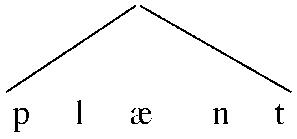

[О критерии слогоделения в современном русском языке](https://www.philol.msu.ru/~ruslang/data/pdf/vya1999-1.pdf)

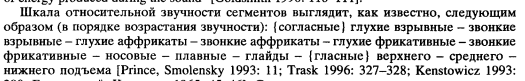

In [ ]:
tokenizer = SyllableTokenizer(
    lang='ru',
    sonority_hierarchy=[
        'аеёиоуыэюя', # гласные
        'мн', # носовые
        'вфзсжшх', # фрикативные
        'рпбдткгщ', # стоповые
    ] # https://www.philol.msu.ru/~fonetica/kons/n-12.htm
)
print(tokenizer.tokenize('антидопинговых'))

['ан', 'ти', 'до', 'пин', 'го', 'вых']


#### Spacy

[SpaCy](https://spacy.io/) — это библиотека с открытым исходным кодом для расширенной обработки естественного языка в Python.


[Fact & Figures](https://spacy.io/usage/facts-figures)

- Support for 72+ languages
- 80 trained pipelines for 24 languages
- Multi-task learning with pretrained transformers like BERT
- Pretrained word vectors
- State-of-the-art speed
- Production-ready training system
- Linguistically-motivated tokenization
- Components for named entity recognition, part-of-speech tagging, dependency parsing, sentence segmentation, text classification, lemmatization, morphological analysis, entity linking and more
- Easily extensible with custom components and attributes
- Support for custom models in PyTorch, TensorFlow and other frameworks
- Built in visualizers for syntax and NER
- Easy model packaging, deployment and workflow management
- Robust, rigorously evaluated accuracy

In [ ]:
import spacy
from spacy import displacy

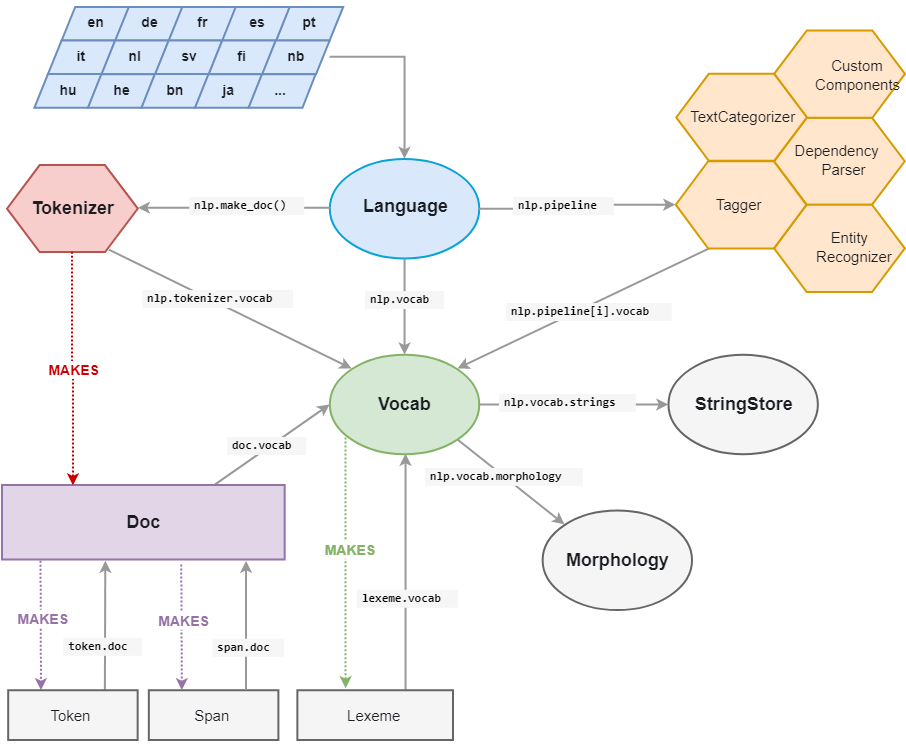

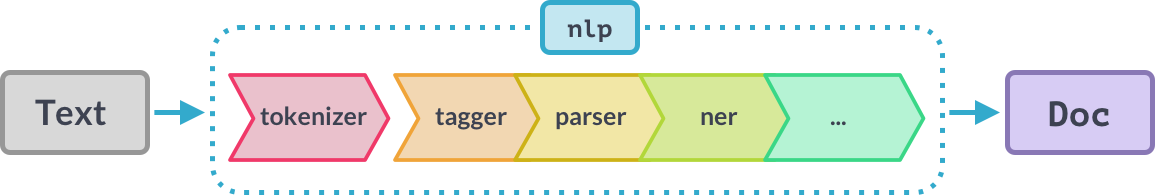

In [ ]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 70.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("ru_core_news_sm")
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
sentences[0]

'\nАвстрийские правоохранительные органы не представили доказательств нарушения\nроссийскими биатлонистами антидопинговых правил.'

In [ ]:
doc = nlp(sentences[0])
for token in doc:
    print(token.text)



Австрийские
правоохранительные
органы
не
представили
доказательств
нарушения


российскими
биатлонистами
антидопинговых
правил
.


#### Razdel

[Razdel](https://natasha.github.io/razdel/) — сегментация русскоязычного текста на токены и предложения

Сложности в русском языке:
- сокращения
- инициалы
- списки
- смайлики в конце предложения
- цитаты

Пайплайн работы:

`поиск кандидатов на конец предложения` -> `отсеивание лишних эвристиками` -> `все, что осталось, - токены`

Ограничения:

- Правила в Razdel оптимизированы для аккуратно написанных текстов с правильной пунктуацией. Решение хорошо работает с новостными статьями, художественными текстами. На постах из социальных сетей, расшифровках телефонных разговоров качество ниже.

- Если между предложениями нет пробела или в конце нет точки или предложение начинается с маленькой буквы, Razdel сделает ошибку.

[Замеры качества работы](https://github.com/natasha/razdel#tokens)

In [ ]:
from razdel import tokenize, sentenize

In [ ]:
russian_text = "Ай да А.С. Пушкин! Ай да сукин сын!"
[_.text for _ in list(sentenize(russian_text))]

['Ай да А.С. Пушкин!', 'Ай да сукин сын!']

In [ ]:
[_.text for _ in list(tokenize(text))]

['Австрийские',
 'правоохранительные',
 'органы',
 'не',
 'представили',
 'доказательств',
 'нарушения',
 'российскими',
 'биатлонистами',
 'антидопинговых',
 'правил',
 '.',
 'Об',
 'этом',
 'сообщил',
 'посол',
 'России',
 'в',
 'Вене',
 'Дмитрий',
 'Любинский',
 'по',
 'итогам',
 'встречи',
 'уполномоченного',
 'адвоката',
 'дипмиссии',
 'с',
 'представителями',
 'прокуратуры',
 'страны',
 ',',
 'передает',
 'ТАСС',
 '.',
 '«',
 'Действует',
 'презумпция',
 'невиновности',
 '.',
 'Каких-либо',
 'ограничений',
 'свободы',
 'передвижения',
 'для',
 'команды',
 'нет',
 '»',
 ',',
 '—',
 'добавили',
 'в',
 'посольстве',
 '.',
 'Международный',
 'союз',
 'биатлонистов',
 '(',
 'IBU',
 ')',
 'также',
 'не',
 'будет',
 'применять',
 'санкции',
 'к',
 'российским',
 'биатлонистам',
 '.',
 'Все',
 'они',
 'продолжат',
 'выступление',
 'на',
 'Кубке',
 'мира',
 '.',
 'Полиция',
 'нагрянула',
 'в',
 'отель',
 'сборной',
 'России',
 'в',
 'Хохфильцене',
 'вечером',
 '12',
 'декабря',
 '.',
 'Ка

#### Морфологический анализ

Морфология - раздел грамматики, изучающий формы слов

[pymorphy2 документация](https://pymorphy2.readthedocs.io/en/stable/user/index.html)

In [ ]:
import pymorphy3

In [ ]:
morph = pymorphy3.MorphAnalyzer()

**OpencorporaTag** - это набор граммем, характеризующих данное слово.

**Граммема** - значение какой-либо грамматической характеристики слова. Например, “множественное число” или “деепричастие”. Множество всех граммем, характеризующих данное слово, образует тег.

Например, тег 'VERB,perf,intr plur,past,indc' означает, что слово - глагол (VERB) совершенного вида (perf), непереходный (intr), множественного числа (plur), прошедшего времени (past), изъявительного наклонения (indc).

In [ ]:
morph.parse('стали')

[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.975342, methods_stack=((DictionaryAnalyzer(), 'стали', 945, 4),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.010958, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 1),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.005479, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 6),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 2),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 5),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 9),))]

In [ ]:
morph.parse('дом')

[Parse(word='дом', tag=OpencorporaTag('NOUN,inan,masc sing,nomn'), normal_form='дом', score=0.570175, methods_stack=((DictionaryAnalyzer(), 'дом', 1375, 0),)),
 Parse(word='дом', tag=OpencorporaTag('NOUN,inan,masc sing,accs'), normal_form='дом', score=0.429824, methods_stack=((DictionaryAnalyzer(), 'дом', 1375, 4),))]

In [ ]:
morph.parse('.')

[Parse(word='.', tag=OpencorporaTag('PNCT'), normal_form='.', score=1.0, methods_stack=((PunctuationAnalyzer(score=0.9), '.'),))]

«Гло́кая ку́здра ште́ко будлану́ла бо́кра и курдя́чит бокрёнка» — искусственная фраза на основе русского языка, в которой все корневые морфемы заменены на бессмысленные сочетания звуков.

In [ ]:
morph.parse('куздра')

[Parse(word='куздра', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Geox sing,nomn'), normal_form='куздра', score=0.15, methods_stack=((DictionaryAnalyzer(), 'дра', 268, 0), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'куз'))),
 Parse(word='куздра', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Geox sing,gent'), normal_form='куздра', score=0.15, methods_stack=((DictionaryAnalyzer(), 'дра', 268, 1), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'куз'))),
 Parse(word='куздра', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Geox sing,datv'), normal_form='куздра', score=0.15, methods_stack=((DictionaryAnalyzer(), 'дра', 268, 2), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'куз'))),
 Parse(word='куздра', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fixd,Abbr,Geox sing,accs'), normal_form='куздра', score=0.15, methods_stack=((DictionaryAnalyzer(), 'дра', 268, 3), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'куз'))),
 Parse(word='куздра', tag=OpencorporaTag('NOUN,inan,femn,Sgtm,Fi

In [ ]:
morph.parse('курдячит')

[Parse(word='курдячит', tag=OpencorporaTag('VERB,impf,intr sing,3per,pres,indc'), normal_form='курдячать', score=0.5384615384615384, methods_stack=((DictionaryAnalyzer(), 'ячит', 564, 5), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'курд'))),
 Parse(word='курдячит', tag=OpencorporaTag('VERB,impf,intr sing,3per,pres,indc'), normal_form='курдячить', score=0.23076923076923075, methods_stack=((FakeDictionary(), 'курдячит', 371, 5), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ячит'))),
 Parse(word='курдячит', tag=OpencorporaTag('VERB,perf,intr sing,3per,futr,indc'), normal_form='курдячить', score=0.23076923076923075, methods_stack=((FakeDictionary(), 'курдячит', 1551, 9), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ячит')))]

[Обозначения для граммем](https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html)

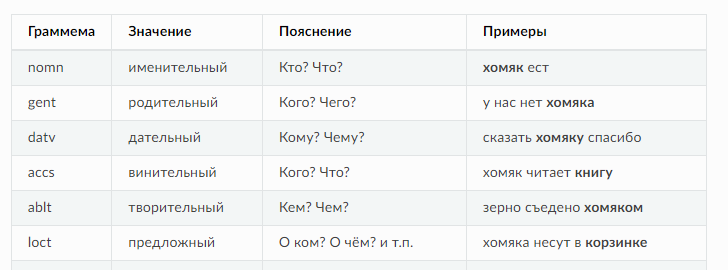

In [ ]:
init = morph.parse('собака')[0]
init.inflect({'datv'})

Parse(word='собаке', tag=OpencorporaTag('NOUN,anim,femn sing,datv'), normal_form='собака', score=1.0, methods_stack=((DictionaryAnalyzer(), 'собаке', 421, 2),))

#### Стемминг

##### NLTK

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

**PorterStemmer** (Стеммер Портера) не использует баз основ слов, а лишь, применяя последовательно ряд правил, отсекает окончания и суффиксы, основываясь на особенностях языка, в связи с чем работает быстро, но не всегда безошибочно.

Всего применяется более 50 правил

```
SSES -> SS (caresses -> caress)
S ->  (cats -> cat)
...
```

In [ ]:
porter = PorterStemmer()
[(word, porter.stem(word)) for word in macbeth[56]][:15]

[('Norway', 'norway'),
 ('himselfe', 'himself'),
 (',', ','),
 ('with', 'with'),
 ('terrible', 'terribl'),
 ('numbers', 'number'),
 (',', ','),
 ('Assisted', 'assist'),
 ('by', 'by'),
 ('that', 'that'),
 ('most', 'most'),
 ('disloyall', 'disloyal'),
 ('Traytor', 'traytor'),
 (',', ','),
 ('The', 'the')]

**LancasterStemmer** - Более агрессивный стеммер, использует около 100 правил, и многократно запускает стемминг на одном и том же слове

```
“sei3y>” – if the word ends with “ies”, then replace the last three letters with “y” and then apply the stemmer again to truncated form.
```

In [ ]:
lancaster = LancasterStemmer()
[(word, lancaster.stem(word)) for word in macbeth[56]][:15]

[('Norway', 'norway'),
 ('himselfe', 'himself'),
 (',', ','),
 ('with', 'with'),
 ('terrible', 'terr'),
 ('numbers', 'numb'),
 (',', ','),
 ('Assisted', 'assist'),
 ('by', 'by'),
 ('that', 'that'),
 ('most', 'most'),
 ('disloyall', 'disloyal'),
 ('Traytor', 'trayt'),
 (',', ','),
 ('The', 'the')]

**Snowball Stemmer** - улучшенный вариант Стеммера Портера

```
ILY  -----> ILI
LY   -----> Nil
SS   -----> SS
S    -----> Nil
ED   -----> E,Nil
```

In [ ]:
snowball = SnowballStemmer(language='english')
[(word, snowball.stem(word)) for word in ['easily', 'cats', 'cared']]

[('easily', 'easili'), ('cats', 'cat'), ('cared', 'care')]

#### Лемматизация

##### pymorphy2

In [ ]:
morph.parse('собаками')[0].normal_form

'собака'

##### NLTK

In [ ]:
from nltk.stem import WordNetLemmatizer

Wordnet — это большая, свободно распространяемая и общедоступная лексическая база данных для английского языка с целью установления структурированных семантических отношений между словами

In [ ]:
nltk.download('wordnet')
wnl = WordNetLemmatizer()
[(word, wnl.lemmatize(word)) for word in word_tokenize(text)]

[nltk_data] Downloading package wordnet to /root/nltk_data...


[('Австрийские', 'Австрийские'),
 ('правоохранительные', 'правоохранительные'),
 ('органы', 'органы'),
 ('не', 'не'),
 ('представили', 'представили'),
 ('доказательств', 'доказательств'),
 ('нарушения', 'нарушения'),
 ('российскими', 'российскими'),
 ('биатлонистами', 'биатлонистами'),
 ('антидопинговых', 'антидопинговых'),
 ('правил', 'правил'),
 ('.', '.'),
 ('Об', 'Об'),
 ('этом', 'этом'),
 ('сообщил', 'сообщил'),
 ('посол', 'посол'),
 ('России', 'России'),
 ('в', 'в'),
 ('Вене', 'Вене'),
 ('Дмитрий', 'Дмитрий'),
 ('Любинский', 'Любинский'),
 ('по', 'по'),
 ('итогам', 'итогам'),
 ('встречи', 'встречи'),
 ('уполномоченного', 'уполномоченного'),
 ('адвоката', 'адвоката'),
 ('дипмиссии', 'дипмиссии'),
 ('с', 'с'),
 ('представителями', 'представителями'),
 ('прокуратуры', 'прокуратуры'),
 ('страны', 'страны'),
 (',', ','),
 ('передает', 'передает'),
 ('ТАСС', 'ТАСС'),
 ('.', '.'),
 ('«', '«'),
 ('Действует', 'Действует'),
 ('презумпция', 'презумпция'),
 ('невиновности', 'невиновности'),

In [ ]:
[(word, wnl.lemmatize(word)) for word in macbeth[56]][:15]

[('Norway', 'Norway'),
 ('himselfe', 'himselfe'),
 (',', ','),
 ('with', 'with'),
 ('terrible', 'terrible'),
 ('numbers', 'number'),
 (',', ','),
 ('Assisted', 'Assisted'),
 ('by', 'by'),
 ('that', 'that'),
 ('most', 'most'),
 ('disloyall', 'disloyall'),
 ('Traytor', 'Traytor'),
 (',', ','),
 ('The', 'The')]

### Разбиение на train/test

In [ ]:
df_f = df.drop_duplicates("text_norm_simple").copy()

X = df_f["comment"].values
y = df_f["toxic"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

len(X_train), len(X_test), y_train.mean(), y_test.mean()

(11324, 2831, np.float64(0.3338926174496644), np.float64(0.33380430943129635))

###  Предобработка

In [ ]:
morph = pymorphy3.MorphAnalyzer()

URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
USER_RE = re.compile(r"@\w+")
NUM_RE = re.compile(r"\b\d+([.,]\d+)?\b")

def normalize_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" __url__ ", s)
    s = USER_RE.sub(" __user__ ", s)
    s = NUM_RE.sub(" __num__ ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Узкое место: лемматизация
def lemmatize_razdel(s: str) -> str:
    tokens = [t.text for t in razdel.tokenize(s)]
    lemmas = []
    for t in tokens:
        if re.fullmatch(r"[a-zа-яё]+", t):
            lemmas.append(morph.parse(t)[0].normal_form)
        else:
            lemmas.append(t)
    return " ".join(lemmas)

USE_LEMMAS = True

def preprocessor(s: str) -> str:
    s = normalize_text(s)
    if USE_LEMMAS:
        s = lemmatize_razdel(s)
    return s

In [ ]:
vectorizer_for_cleanlab = TfidfVectorizer(
    preprocessor=preprocessor,
    token_pattern=r"(?u)\b[\wёЁ]+\b",
    ngram_range=(1, 2),
    min_df=3,
    max_features=200_000,
    sublinear_tf=True
)

base_clf = LogisticRegression(
    solver="saga",
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced",
    C=2.0
)

pipe_cleanlab = Pipeline([
    ("tfidf", vectorizer_for_cleanlab),
    ("clf", base_clf),
])

In [ ]:
def oof_pred_proba(pipe, X, y, n_splits=3, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    proba = np.zeros((len(X), 2), dtype=np.float32)

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        p = clone(pipe)
        p.fit(X[tr], y[tr])
        proba[va] = p.predict_proba(X[va])
        print(f"fold={fold} done")
    return proba

In [ ]:
%%time

# для скорости можно взять подвыборку
MAX_CLEANLAB = 5_000
if len(X_train) > MAX_CLEANLAB:
    idx = np.random.choice(len(X_train), MAX_CLEANLAB, replace=False)
    X_cl, y_cl = X_train[idx], y_train[idx]
else:
    X_cl, y_cl = X_train, y_train

pred_probs = oof_pred_proba(pipe_cleanlab, X_cl, y_cl, n_splits=3, random_state=RANDOM_STATE)

fold=1 done
fold=2 done
fold=3 done
CPU times: user 1min 17s, sys: 81.4 ms, total: 1min 17s
Wall time: 1min 28s


In [ ]:
issues = find_label_issues(
    labels=y_cl,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence"  # самые "сомнительные" сверху
)

print("Potential label issues:", len(issues), " / ", len(y_cl))
issues[:10]

Potential label issues: 373  /  5000


array([ 478, 2446,  721, 4204, 2586, 3102, 1910, 2839, 3328, 1906])

In [ ]:
def show_issues(X, y, pred_probs, issues, n=15):
    rows = []
    for i in issues[:n]:
        rows.append({
            "idx": int(i),
            "text": X[i][:300],
            "label": int(y[i]),
            "p0": float(pred_probs[i,0]),
            "p1": float(pred_probs[i,1]),
            "pred": int(pred_probs[i,1] >= 0.5),
            "self_conf": float(pred_probs[i, y[i]]),
        })
    return pd.DataFrame(rows)

show_issues(X_cl, y_cl, pred_probs, issues, n=20)

,idx,text,label,p0,p1,pred,self_conf
0,478,Пустоту тебе сфотографировать?)\n,0,0.000532,0.999468,1,0.000532
1,2446,Эк ты витиевато конский хуй назвал...\n,0,0.014765,0.985235,1,0.014765
2,721,Ты крутая. Бэнкси отдыхает\n,0,0.037059,0.962941,1,0.037059
3,4204,внучатый племянник ты это когда твоего прямого...,0,0.039386,0.960614,1,0.039386
4,2586,Ты ему еще и полтос накинул\n,0,0.045036,0.954964,1,0.045036
5,3102,"Ты что, спишь, я тебе за руль звоню\n",0,0.046829,0.953171,1,0.046829
6,1910,Могу тебе отдать свои старые семейники,0,0.047016,0.952984,1,0.047016
7,2839,А ты во всех постах будешь спамить этой гифкой?\n,0,0.047450,0.952550,1,0.047450
8,3328,вы растекаетесь по всей борде лишим вас загонч...,0,0.053722,0.946278,1,0.053722
9,1906,Ты чо. Нивстиме значит пидоры. Нахуй их гогвер...,0,0.060026,0.939974,1,0.060026


### BoW + LogReg

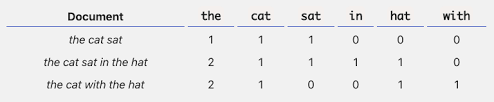

#### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [ ]:
%%time

bow_pipe = Pipeline([
    ("vect", CountVectorizer(
        preprocessor=preprocessor,
        token_pattern=r"(?u)\b[\wёЁ]+\b",
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.7
    )),
    ("clf", LogisticRegression(
        solver="saga",
        max_iter=500,
        n_jobs=-1,
        class_weight="balanced",
        C=2.0
    ))
])

bow_pipe.fit(X_train, y_train)

CPU times: user 58.8 s, sys: 83.5 ms, total: 58.9 s
Wall time: 1min


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x79503707bd80>,
                                 token_pattern='(?u)\\b[\\wёЁ]+\\b')),
                ('clf',
                 LogisticRegression(C=2.0, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, solver='saga'))])

### Tf-Idf + LogReg

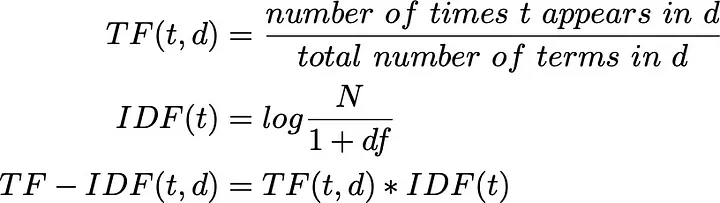

#### Отличия в реализации Sklearn

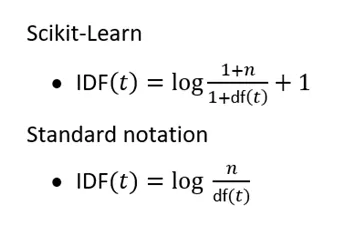

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

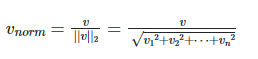

In [ ]:
%%time

tfidf_pipe = Pipeline([
    ("vect", TfidfVectorizer(
        preprocessor=preprocessor,
        token_pattern=r"(?u)\b[\wёЁ]+\b",
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.7,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        solver="saga",
        max_iter=500,
        n_jobs=-1,
        class_weight="balanced",
        C=2.0
    ))
])

tfidf_pipe.fit(X_train, y_train)

CPU times: user 53.6 s, sys: 82.2 ms, total: 53.7 s
Wall time: 54.1 s


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x79503707bd80>,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b[\\wёЁ]+\\b')),
                ('clf',
                 LogisticRegression(C=2.0, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, solver='saga'))])

### Оценка качества

In [ ]:
def eval_model(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    print("ROC-AUC:", roc_auc_score(y_test, proba))
    print("PR-AUC :", average_precision_score(y_test, proba))
    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix @0.5")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()

    # кривые
    fpr, tpr, _ = roc_curve(y_test, proba)
    pr, rc, _ = precision_recall_curve(y_test, proba)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title("ROC"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[1].plot(rc, pr)
    ax[1].set_title("PR"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    plt.show()

    return proba

ROC-AUC: 0.858103990977798
PR-AUC : 0.7649894390217482
              precision    recall  f1-score   support

           0     0.8321    0.9014    0.8654      1886
           1     0.7640    0.6370    0.6947       945

    accuracy                         0.8131      2831
   macro avg     0.7980    0.7692    0.7801      2831
weighted avg     0.8094    0.8131    0.8084      2831



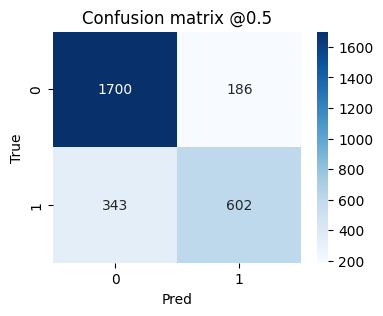

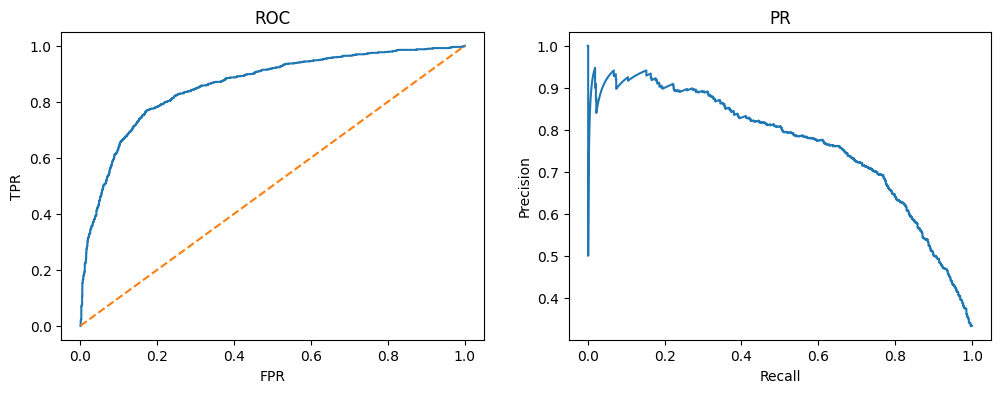

In [ ]:
bow_proba = eval_model(bow_pipe, X_test, y_test)

ROC-AUC: 0.9365679723049818
PR-AUC : 0.880641207191295
              precision    recall  f1-score   support

           0     0.9052    0.9115    0.9083      1886
           1     0.8208    0.8095    0.8151       945

    accuracy                         0.8774      2831
   macro avg     0.8630    0.8605    0.8617      2831
weighted avg     0.8770    0.8774    0.8772      2831



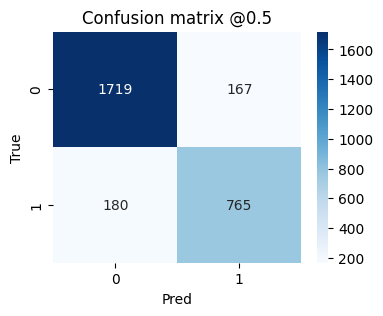

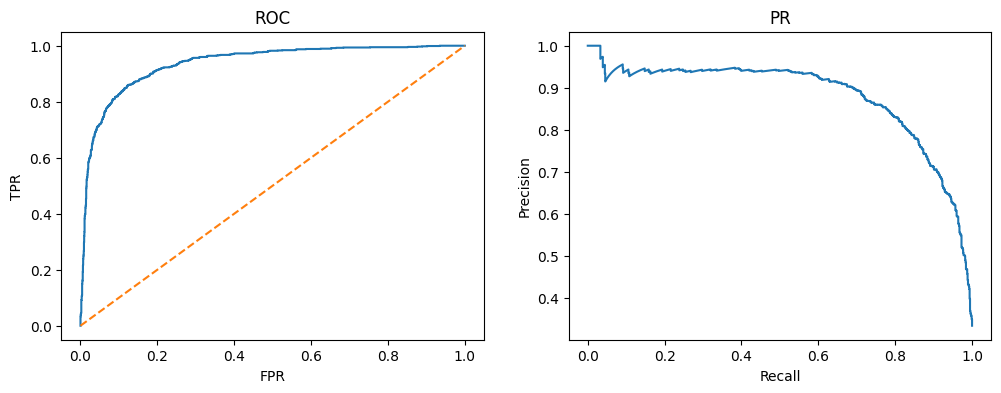

In [ ]:
tfidf_proba = eval_model(tfidf_pipe, X_test, y_test)

### Подбор гиперпараметров

#### Ускорим предобработку!

In [ ]:
from functools import lru_cache

# важно не создавать MorphAnalyzer внутри функции!!!
morph = pymorphy3.MorphAnalyzer()

URL_RE  = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
USER_RE = re.compile(r"@\w+")
NUM_RE  = re.compile(r"\b\d+([.,]\d+)?\b", re.UNICODE)
WS_RE   = re.compile(r"\s+", re.UNICODE)
WORD_RE = re.compile(r"^[a-zа-яё]+$", re.IGNORECASE)

def normalize_text(s):
    s = s.lower()
    s = URL_RE.sub(" __url__ ", s)
    s = USER_RE.sub(" __user__ ", s)
    s = NUM_RE.sub(" __num__ ", s)
    s = WS_RE.sub(" ", s).strip()
    return s

# Кеш на уровне токенов
@lru_cache(maxsize=100_000)
def lemma_token_cached(token):
    if WORD_RE.match(token):
        return morph.parse(token)[0].normal_form
    return token

def preprocess_one_cached(s):
    s = normalize_text(s)
    tokens = [t.text for t in razdel.tokenize(s)]
    lemmas = [lemma_token_cached(t) for t in tokens]
    return " ".join(lemmas)

def preprocess_corpus(texts):
    out = [preprocess_one_cached(str(t)) for t in texts]
    return np.asarray(out, dtype=object)

In [ ]:
def preprocess_before(texts):
    out = []
    for t in texts:
        s = normalize_text(str(t))
        s = lemmatize_razdel(s)  # без кеша
        out.append(s)
    return np.asarray(out, dtype=object)

def preprocess_after(texts):
    return preprocess_corpus(texts)

def bench_preproc(fn, texts, name="", repeat=3, warmup=1):
    texts = np.asarray(texts, dtype=object)

    # прогрев - важно для кешей
    for _ in range(warmup):
        _ = fn(texts[:500])

    gc.collect()
    tracemalloc.start()

    times = []
    for _ in range(repeat):
        t0 = time.perf_counter()
        _ = fn(texts)
        times.append(time.perf_counter() - t0)

    cur, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(
        f"{name} | time: {np.mean(times):.3f}s +- {np.std(times):.3f}s "
        f"| peak mem: {peak/1024/1024:} MB | n={len(texts)}"
    )

In [ ]:
# Запуск на подвыборке
N = 100
texts = X_train[:N]

bench_preproc(preprocess_before, texts, name="BEFORE", repeat=3, warmup=1)
bench_preproc(preprocess_after,  texts, name="AFTER",  repeat=3, warmup=1)

print("lemma_token_cached:", lemma_token_cached.cache_info())

BEFORE | time: 3.428s +- 0.542s | peak mem: 0.15635013580322266 MB | n=100
AFTER | time: 0.082s +- 0.002s | peak mem: 0.13399696350097656 MB | n=100
lemma_token_cached: CacheInfo(hits=10963, misses=1377, maxsize=100000, currsize=1377)


#### Подбираем параметры

In [ ]:
cache_dir = "/content/joblib_cache"
memory = Memory(cache_dir, verbose=0)

prep_step = FunctionTransformer(
    preprocess_corpus,
    validate=False,
    feature_names_out="one-to-one"
)

tfidf_vec = TfidfVectorizer(
    token_pattern=r"\b[\wёЁ]+\b",
    # preprocessor  второй раз не задаем
)

clf = LogisticRegression(
    solver="saga",
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",
)

tfidf_lr_pipe_cached = Pipeline(
    steps=[
        ("prep", prep_step),
        ("vect", tfidf_vec),
        ("clf", clf),
    ],
    memory=memory
)

In [ ]:
%%time

param_dist = {
    "vect__ngram_range": [(1, 1), (1, 2)],
    "vect__min_df": [2, 3, 5],
    "vect__max_df": [0.5, 0.7],
    "vect__sublinear_tf": [True, False],
    "clf__C": np.logspace(-2, 1, 15),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=tfidf_lr_pipe_cached,
    param_distributions=param_dist,
    n_iter=15,
    scoring="average_precision",
    n_jobs=1,
    cv=cv,
    verbose=1,
    random_state=42,
)

# первый прогон создаст кеш предобработки, последующие итерации будут переиспользовать
rs.fit(X_train, y_train)

best_model = rs.best_estimator_
rs.best_score_, rs.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
CPU times: user 1min 37s, sys: 259 ms, total: 1min 37s
Wall time: 1min 38s


(np.float64(0.8753112513582663),
 {'vect__sublinear_tf': False,
  'vect__ngram_range': (1, 2),
  'vect__min_df': 2,
  'vect__max_df': 0.5,
  'clf__C': np.float64(10.0)})

### Интерпретация

In [ ]:
def top_linear_features(pipe: Pipeline, top_k=30):
    vect = pipe.named_steps["vect"]
    clf = pipe.named_steps["clf"]
    feat_names = np.array(vect.get_feature_names_out())
    coefs = clf.coef_.ravel()

    top_pos = np.argsort(coefs)[-top_k:][::-1]
    top_neg = np.argsort(coefs)[:top_k]

    return (
        pd.DataFrame({"feature": feat_names[top_pos], "coef": coefs[top_pos]}),
        pd.DataFrame({"feature": feat_names[top_neg], "coef": coefs[top_neg]}),
    )

pos, neg = top_linear_features(best_model, top_k=30)
pos.head(20), neg.head(20)

(      feature       coef
 0          ты  11.720492
 1       хохол  11.278550
 2       тупой   9.851034
 3      хохлов   9.305564
 4       шлюха   8.687516
 5       блядь   8.367017
 6     русский   7.662015
 7       дебил   7.624496
 8       быдло   7.168408
 9        баба   6.802653
 10       мозг   6.612396
 11  пидорашка   6.419287
 12       сука   6.018738
 13    педофил   5.986700
 14      хуйня   5.866469
 15      нахуй   5.845329
 16      пидор   5.793451
 17     пиздец   5.667002
 18      рашка   5.581346
 19      дурак   5.533558,
       feature      coef
 0     спасибо -7.044374
 1          но -5.708842
 2        если -5.691214
 3      деньга -5.448624
 4      купить -5.436478
 5       очень -5.429102
 6      разный -5.408888
 7    например -5.311892
 8       можно -4.912985
 9       город -4.867107
 10    телефон -4.775005
 11   красивый -4.607375
 12  интересно -4.513302
 13        у я -4.368263
 14       у мы -4.355377
 15    конечно -4.285090
 16      фильм -4.280665
 17

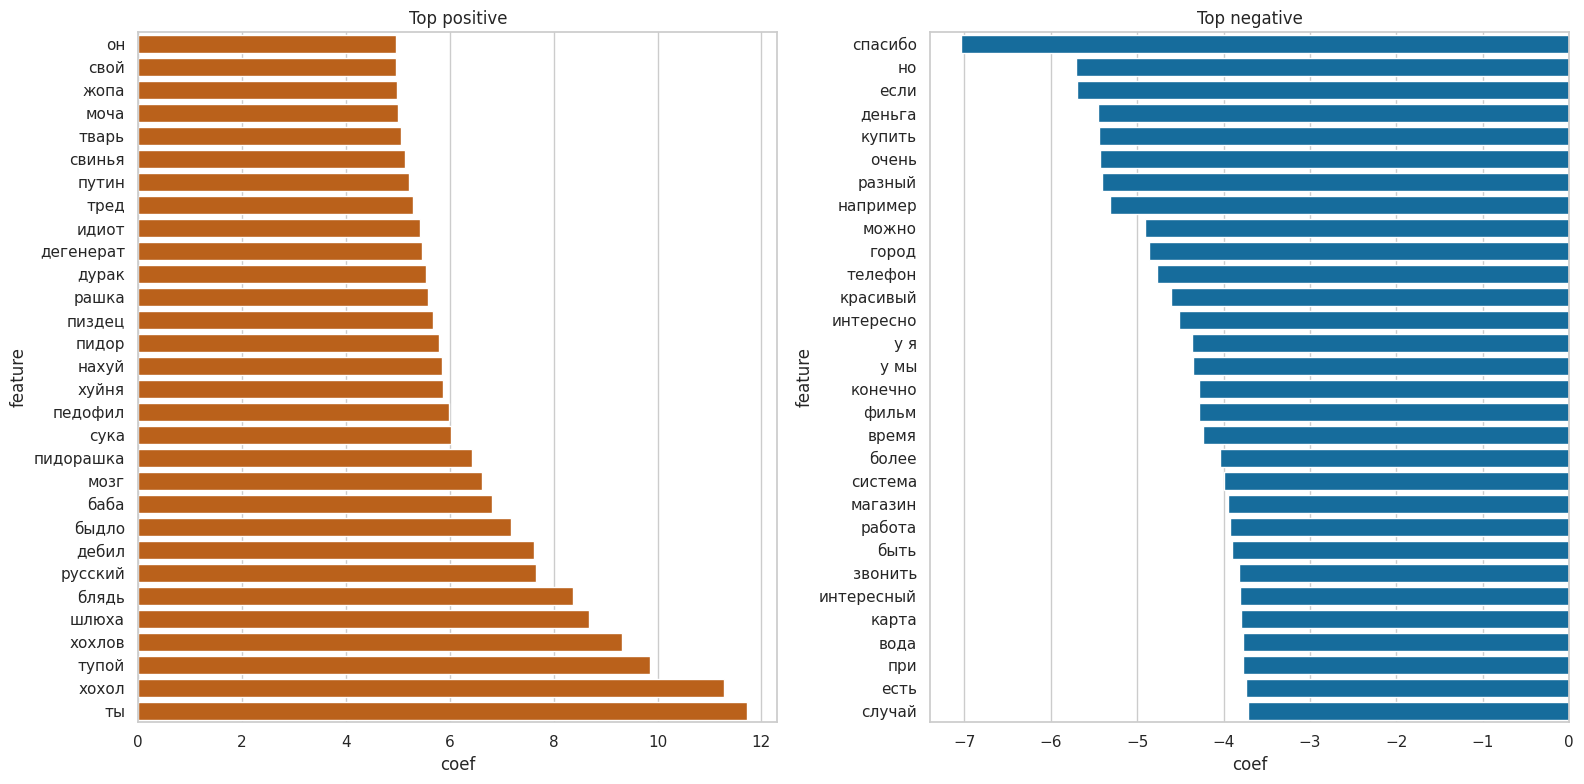

In [ ]:
sns.set(style="whitegrid", font_scale=1.0)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Положительные
sns.barplot(
    data=pos.sort_values("coef", ascending=True),
    x="coef", y="feature",
    ax=axes[0], color="#d55e00"
)
axes[0].set_title("Top positive")
axes[0].set_xlabel("coef"); axes[0].set_ylabel("feature")

# Отрицательные
sns.barplot(
    data=neg.sort_values("coef", ascending=True),
    x="coef", y="feature",
    ax=axes[1], color="#0072b2"
)
axes[1].set_title("Top negative")
axes[1].set_xlabel("coef"); axes[1].set_ylabel("feature")

plt.tight_layout()
plt.show()

### Анализ ошибок

#### FP/FN

In [ ]:
proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

errors = pd.DataFrame({"text": X_test, "y": y_test, "p": proba, "pred": pred})
fp = errors[(errors.y==0) & (errors.pred==1)].sort_values("p", ascending=False)
fn = errors[(errors.y==1) & (errors.pred==0)].sort_values("p", ascending=True)

len(fp), len(fn)

(147, 195)

In [ ]:
fp.head(10)

,text,y,p,pred
819,Дрозд-рябинник поедающий боярышник: забыл лицо...,0,0.998226,1
368,какой пруф тебя устроит?\n,0,0.995252,1
2099,То на них пьяное быдло просто так напало и они...,0,0.994444,1
273,"обезьяна ковыряется в жопе, нюхает палец и пад...",0,0.993084,1
2061,"Бля, че за болезнь? У мен походу такое же дерь...",0,0.989706,1
2016,По-моему это прокачка жопы головного мозга . В...,0,0.988718,1
1533,Хули ты тут рыбой машеш? Где блядь тевтонцы????\n,0,0.988257,1
2082,Ну хочешь я стану твоим другом? Как тебя зовут...,0,0.987167,1
2787,Ты о нем уже третий пост мне пишешь. Зачем ты ...,0,0.985048,1
1816,"Не, нихуя. Любой идиот знает, что Абдуль прост...",0,0.980965,1


In [ ]:
fn.head(10)

,text,y,p,pred
1937,"Не то, чтобы раздражают.. Это как при задержан...",1,0.001743,0
401,Спасибо консолеблядям за бета-тест.\n,1,0.004813,0
1881,"так и машин от силы 5, зачем вам еще более шир...",1,0.018062,0
1684,"Мне кажется, что маленькая надпись СХС-54 на p...",1,0.030789,0
1247,"В этой истории никто не знал, чем кончится, по...",1,0.034308,0
492,Где-то сжигают книги.. А где-то фотографов. Во...,1,0.043101,0
1693,"та шо там хаварить, скатился пожилая скумбрия....",1,0.052801,0
1116,"За госуслуги с показыванием номера телефона, п...",1,0.053267,0
493,Посмотри любой мотиватор к богатству ТАМ ГОВОР...,1,0.055427,0
1090,А шлюхочасы позобавили. Хлопцам на работе расс...,1,0.060764,0


#### Качество VS длина текста

In [ ]:
errors["len_words"] = pd.Series(errors["text"]).str.split().str.len().values
errors["bin"] = pd.cut(
    errors["len_words"],
    bins=[0, 3, 8, 15, 30, 1000],
    include_lowest=True,
)

grp = errors.groupby("bin").apply(lambda g: pd.Series({
    "n": len(g),
    "pr_auc_proxy": average_precision_score(g["y"], g["p"]) if g["y"].nunique() > 1 else np.nan
}))
grp

,n,pr_auc_proxy
bin,,
"(-0.001, 3.0]",48.0,0.967525
"(3.0, 8.0]",578.0,0.891013
"(8.0, 15.0]",713.0,0.869517
"(15.0, 30.0]",740.0,0.901759
"(30.0, 1000.0]",752.0,0.859669


#### Анализ по порогам

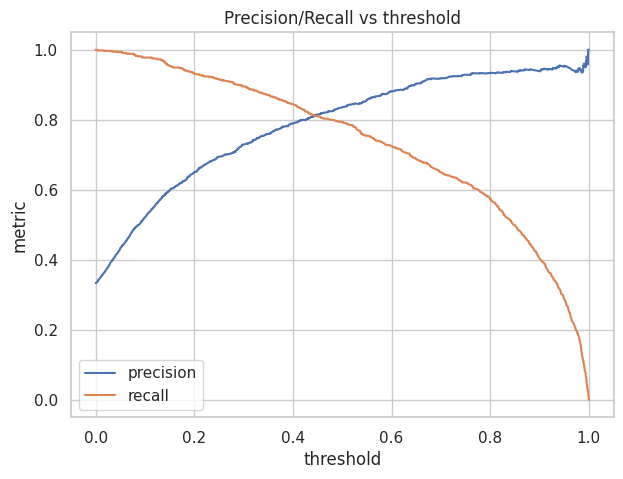

In [ ]:
prec, rec, thr = precision_recall_curve(y_test, proba)

plt.figure(figsize=(7,5))
plt.plot(thr, prec[:-1], label="precision")
plt.plot(thr, rec[:-1], label="recall")
plt.xlabel("threshold"); plt.ylabel("metric")
plt.title("Precision/Recall vs threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def confusion_at_threshold(y_true, proba, t):
    pred = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {"t": t, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

for t in [0.2, 0.3, 0.5, 0.7, 0.9]:
    print(confusion_at_threshold(y_test, proba, t))

{'t': 0.2, 'tp': np.int64(881), 'fp': np.int64(476), 'tn': np.int64(1410), 'fn': np.int64(64)}
{'t': 0.3, 'tp': np.int64(846), 'fp': np.int64(313), 'tn': np.int64(1573), 'fn': np.int64(99)}
{'t': 0.5, 'tp': np.int64(750), 'fp': np.int64(147), 'tn': np.int64(1739), 'fn': np.int64(195)}
{'t': 0.7, 'tp': np.int64(614), 'fp': np.int64(55), 'tn': np.int64(1831), 'fn': np.int64(331)}
{'t': 0.9, 'tp': np.int64(381), 'fp': np.int64(25), 'tn': np.int64(1861), 'fn': np.int64(564)}


#### Калибровка

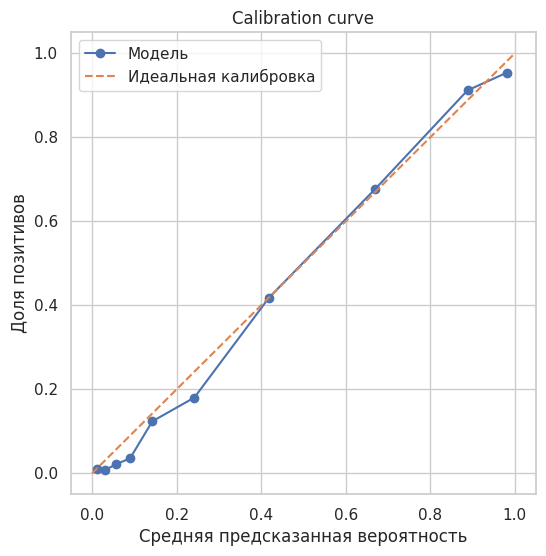

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Модель")
plt.plot([0,1],[0,1],"--", label="Идеальная калибровка")
plt.xlabel("Средняя предсказанная вероятность"); plt.ylabel("Доля позитивов")
plt.title("Calibration curve")
plt.legend()
plt.grid(True)
plt.show()